In [29]:
import pandas as pd

In [30]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

from configs.config import RAW_DATA_DIR
import pandas as pd

metadata_path = RAW_DATA_DIR/'lung_data'/'dataset_metadata.csv'
df = pd.read_csv(metadata_path)

df.head()

,SeriesInstanceUID,StudyInstanceUID,Modality,ProtocolName,SeriesDate,BodyPartExamined,SeriesNumber,Collection,Site,PatientID,...,LicenseName,LicenseURI,DataDescriptionURI,FileSize,ReleasedStatus,DateReleased,StudyDate,ThirdPartyAnalysis,Authorized,SeriesDescription
0,1.3.6.1.4.1.32722.99.99.3208985276719002650392...,1.3.6.1.4.1.32722.99.99.2923185306557238260155...,CT,MAASTRO_PETCT_WholeBodyC,04-13-2006,LUNG,0,NSCLC-Radiomics,MAASTRO,LUNG1-048,...,Creative Commons Attribution-NonCommercial 3.0...,https://creativecommons.org/licenses/by-nc/3.0/,https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI,71041260,Yes,10-22-2020,04-13-2006,NO,1,NaN


In [31]:
df.columns

Index(['SeriesInstanceUID', 'StudyInstanceUID', 'Modality', 'ProtocolName',
       'SeriesDate', 'BodyPartExamined', 'SeriesNumber', 'Collection', 'Site',
       'PatientID', 'PatientSex', 'PatientAge', 'Manufacturer',
       'ManufacturerModelName', 'SoftwareVersions', 'ImageCount',
       'MaxSubmissionTimestamp', 'LicenseName', 'LicenseURI',
       'DataDescriptionURI', 'FileSize', 'ReleasedStatus', 'DateReleased',
       'StudyDate', 'ThirdPartyAnalysis', 'Authorized', 'SeriesDescription'],
      dtype='str')

In [32]:
df['PatientAge']

0    064Y
Name: PatientAge, dtype: str

In [33]:
df['ImageCount']

0    135
Name: ImageCount, dtype: int64

In [34]:
series_dir = list((RAW_DATA_DIR/'lung_data').iterdir())[0]
files = list(series_dir.iterdir())

In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

In [35]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

In [36]:
dicom_files = sorted(
    [f for f in files if f.suffix == ".dcm"],
    key=lambda x: pydicom.dcmread(x).InstanceNumber
)

len(dicom_files)

135

In [37]:
slices = [pydicom.dcmread(f) for f in dicom_files]
volume = np.stack([s.pixel_array for s in slices])
volume.shape

(135, 512, 512)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

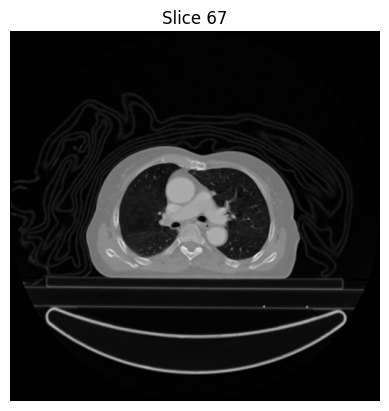

In [38]:
slice_idx = volume.shape[0]//2
plt.imshow(volume[slice_idx], cmap="gray")
plt.title(f"Slice {slice_idx}")
plt.axis("off")

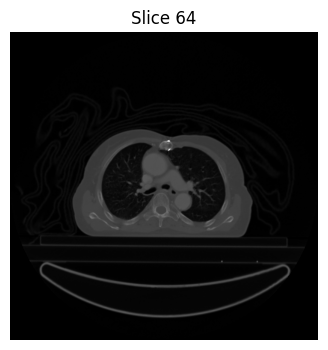

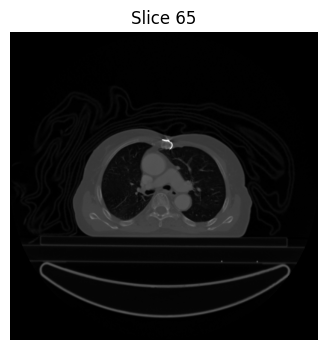

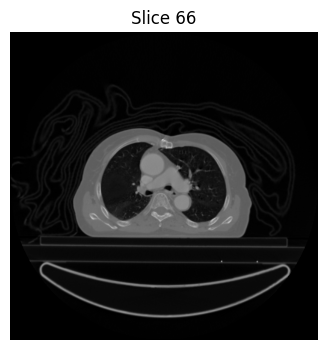

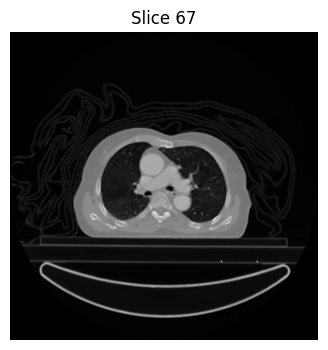

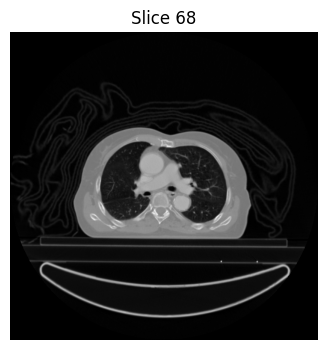

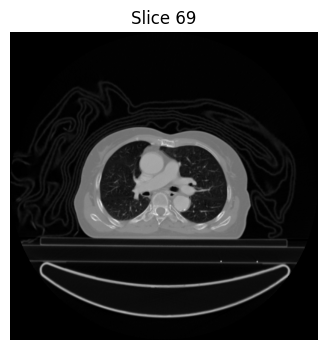

In [39]:
for i in range(slice_idx-3, slice_idx+3):
    plt.figure(figsize=(4, 4))
    plt.imshow(volume[i], cmap="gray")
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()

In [40]:
def convert_to_hu(slices):
    images = np.stack([s.pixel_array for s in slices]).astype(np.int16)

    for i, s in enumerate(slices):
        intercept = s.RescaleIntercept
        slope = s.RescaleSlope
        if slope != 1:
            images[i] = slope * images[i].astype(np.float64)
            images[i] = images[i].astype(np.int16)
        images[i] += np.int16(intercept)

    return images

In [41]:
hu_volume = convert_to_hu(slices)
hu_volume.shape

(135, 512, 512)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

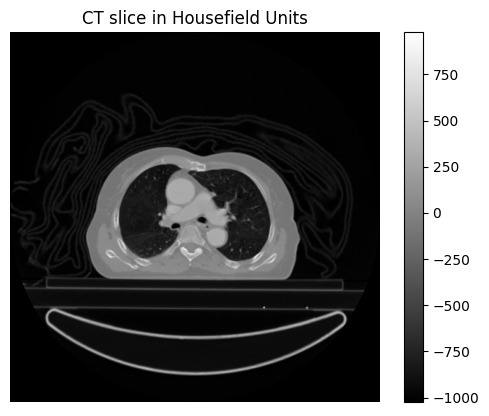

In [42]:
slice_idx = hu_volume.shape[0]//2
plt.imshow(hu_volume[slice_idx], cmap="gray")
plt.colorbar()
plt.title("CT slice in Housefield Units")
plt.axis("off")

In [43]:
def window_image(image, min_hu=-1000, max_hu=400):
    image = np.clip(image, min_hu, max_hu)
    image = (image - min_hu) / (max_hu - min_hu)
    return image

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

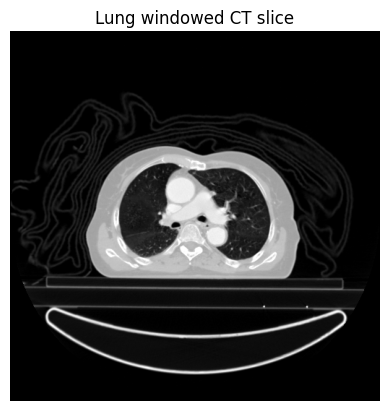

In [44]:
lung_window = window_image(hu_volume[slice_idx])

plt.imshow(lung_window, cmap="gray")
plt.title("Lung windowed CT slice")
plt.axis("off")

In [45]:
hu_slice = hu_volume[slice_idx]
hu_slice.min(), hu_slice.max()

(np.int16(-1024), np.int16(978))

In [46]:
lung_window.min(), lung_window.max()

(np.float64(0.0), np.float64(1.0))

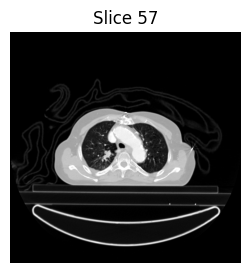

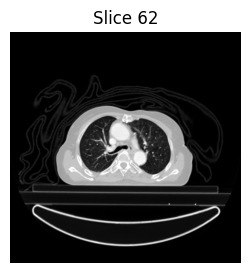

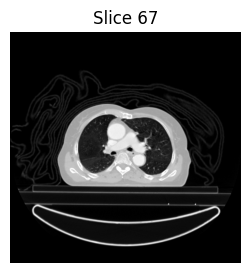

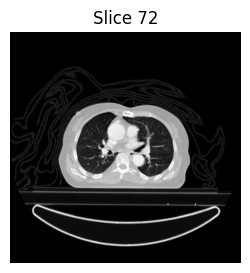

In [47]:
for i in range(slice_idx-10, slice_idx+10, 5):
    plt.figure(figsize=(3, 3))
    plt.imshow(window_image(hu_volume[i]), cmap='grey')
    plt.title(f"Slice {i}")
    plt.axis("off")
    plt.show()

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

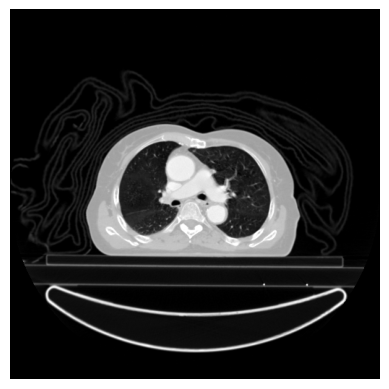

In [49]:
from src.preprocessing import convert_to_hu, window_image

hu_volume = convert_to_hu(slices)
lung_window = window_image(hu_volume[slice_idx])

plt.imshow(lung_window, cmap="grey")
plt.axis("off")

In [50]:
first_slice = slices[0]

print("Pixel Spacing (row, col) in mm: ", first_slice.PixelSpacing)
print("Slice Thickness in mm:", first_slice.SliceThickness)

Pixel Spacing (row, col) in mm:  [0.9765625, 0.9765625]
Slice Thickness in mm: 3


In [51]:
unique_thickness = set(s.SliceThickness for s in slices)
unique_spacing = set(tuple(s.PixelSpacing) for s in slices)

unique_thickness, unique_spacing

({'3'}, {('0.9765625', '0.9765625')})

In [3]:
from src.dataset import LungCTDataset
from configs.config import RAW_DATA_DIR

series_dir = list((RAW_DATA_DIR/'lung_data').iterdir())[0]
dataset = LungCTDataset(series_dir)

print("Pixel spacing (y, x): ", dataset.pixel_scaling)
print("Slice thickness (z): ", dataset.slice_thickness)
print("Voxel spacing (z, y, x): ", dataset.voxel_spacing)

Pixel spacing (y, x):  (0.9765625, 0.9765625)
Slice thickness (z):  3.0
Voxel spacing (z, y, x):  (3.0, 0.9765625, 0.9765625)
